In [1]:
using HDF5
using Plots
using LadderDGA
using Suppressor

path_to_input = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0"
path_to_output = "$(@__DIR__)/../../lDGA_test_runs"
cfg_file = "$(@__DIR__)/../../lDGA_test_runs/config_s1.toml"
empty!(ARGS);
#push!(ARGS,path_to_input);
#push!(ARGS,path_to_output);
#include("../scripts/triqs_conv.jl");

┌ Info: Precompiling LadderDGA [78e40beb-bf89-4c0e-9d2b-bee278912f2b]
└ @ Base loading.jl:1317
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `LadderDGA.find_usable_γ :: Tuple{Any}` in module `LadderDGA`
└ @ Base.Docs docs/Docs.jl:240


Loading impurity quantities and constructing k grids.
removing the @supress block activates debugging output.

In [2]:
#@suppress begin 
    mP, sP, env, kGrids, qGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
    kG = kGrids[1]
    qG = qGrids[1]
    νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);
#end;

┌ Info: Reading Inputs...
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/IO.jl:7
┌ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:107
┌ Info: Inputs Read. Starting Computation.
│ Found usable intervals for local susceptibility of length 
│   sp: 11
│   ch: 11 
│   χLoc_sp = 0.2696, χLoc_ch = 0.0932
└ @ LadderDGA /home/julian/Hamburg/LadderDGA.jl/src/helpers.jl:148


# Potential Issues

## Issue 1: Frequency fits impact tail of trilex

There seems to be some sort of error compensation when inverting $\Gamma$ and extrapolating the $\nu$ sum for $\chi$.

In [3]:
bubble = calc_bubble(νGrid, GLoc_fft, qG, mP, sP);

Internal code for the `calc_χ_trilex` function:

In [4]:
using SharedArrays
using Distributed
using GenericLinearAlgebra
using LinearAlgebra

# emulate function parameters and namespace
Γr = impQ_sp.Γ
U = mP.U
sum_freq = LadderDGA.sum_freq
sumHelper = sumHelper_f
kintegrate = LadderDGA.kintegrate
kGrid = qG
find_usable_interval = LadderDGA.find_usable_interval
sumHelper_ν_nc = LadderDGA.Naive()
sumHelper_ν_rc = LadderDGA.Richardson(LadderDGA.default_fit_range(size(bubble,3)), [0,1,2,3,4])
indh = ceil(Int64, size(bubble,1)/2)
extend_γ! = LadderDGA.extend_γ!

# function starts here
χ_nc = SharedArray{eltype(bubble), 2}((size(bubble)[1:2]...))
γ_nc = SharedArray{eltype(bubble), 3}((size(bubble)...))
χ_rc = SharedArray{eltype(bubble), 2}((size(bubble)[1:2]...))
γ_rc = SharedArray{eltype(bubble), 3}((size(bubble)...))
γ_rc_c1 = SharedArray{eltype(bubble), 3}((size(bubble)...))
γ_rc_c2 = SharedArray{eltype(bubble), 3}((size(bubble)...))
γ_rc_c3 = SharedArray{eltype(bubble), 3}((size(bubble)...))


χ_ω = SharedArray{eltype(bubble), 1}(size(bubble)[1]) 
ωindices = 1:size(bubble,1)
νIndices = 1:size(bubble,3);

In [5]:
# compute quantities
qind = 1 #:size(bubble, 2)
for ωi in indh
    Γview = view(Γr,ωi,νIndices,νIndices)
    UnitM = Matrix{eltype(Γr)}(I, length(νIndices),length(νIndices))
    for qi in qind
        bubble_i = view(bubble,ωi, qi, νIndices)
        bubbleD = Diagonal(bubble_i)
        χ_full = (bubbleD * Γview + UnitM)\bubbleD
        χ_nc[ωi, qi] = sum_freq(χ_full, [1,2], sumHelper_ν_nc, mP.β)[1,1]
        χ_rc[ωi, qi] = sum_freq(χ_full, [1,2], sumHelper_ν_rc, mP.β)[1,1]
        γ_nc[ωi, qi, νIndices] .= sum_freq(χ_full, [1], sumHelper_ν_nc, 1.0)[1,:] ./ (bubble_i * (1.0 + U * χ_nc[ωi, qi]))
        γ_rc[ωi, qi, νIndices] .= sum_freq(χ_full, [1], sumHelper_ν_rc, 1.0)[1,:] ./ (bubble_i * (1.0 + U * χ_rc[ωi, qi]))
        γ_rc_c1 = copy(γ_rc)
        γ_rc_c2 = copy(γ_rc)
        γ_rc_c3 = copy(γ_rc)
        extend_γ!(view(γ_rc_c1,ωi, qi, :), 2*π/mP.β)
        γ_2 = sum_freq(χ_full, [1], sumHelper_ν_nc, 1.0)[1,:] ./ (bubble_i * (1.0 + U * χ_rc[ωi, qi]))
        extend_γ!(view(γ_rc_c2,ωi, qi, :), γ_2)
        γ_3 = sum_freq(χ_full, [1], sumHelper_ν_nc, 1.0)[1,:] ./ (bubble_i * (1.0 + U * χ_nc[ωi, qi]))
        extend_γ!(view(γ_rc_c3, ωi, qi, :), γ_3)
        χ_ω[ωi] = kintegrate(kGrid, χ_nc[ωi,:])[1]
    end
end
usable = find_usable_interval(real(χ_ω))

21:21

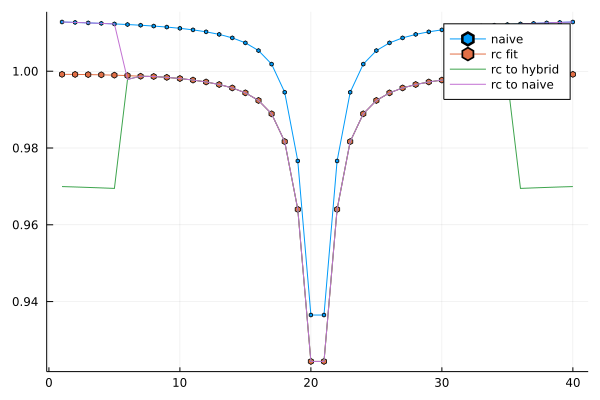

In [6]:
#plot(real.(γ_rc[indh,1,:]))
plot(real.(γ_nc[indh,1,:]), label="naive", markershape=:hexagon, markersize=2)
plot!(real.(γ_rc_c1[indh,1,:]), label="rc fit", markershape=:hexagon, markersize=3)
plot!(real.(γ_rc_c2[indh,1,:]), label="rc to hybrid")
plot!(real.(γ_rc_c3[indh,1,:]), label="rc to naive")

In [7]:
γ_rc_c1[indh,1,:]

40-element Vector{ComplexF64}:
 0.9991906209401963 - 0.0031986606535163472im
 0.9991652803861097 - 0.0029106646370575043im
 0.9991244734747876 - 0.0025947943084560234im
  0.999063521739111 - 0.0022489351509299826im
 0.9989765362417476 - 0.001870973100524832im
  0.998856122911115 - 0.0014588512878079014im
 0.9986930184922074 - 0.0010106467457844685im
 0.9986261046489859 - 0.0012958932989215043im
 0.9983993208183312 - 0.0016338629583344207im
 0.9980949142745263 - 0.002078738753328137im
 0.9976988866855971 - 0.002685458038367005im
 0.9972007583275463 - 0.0035383199841694316im
 0.9965368770069696 - 0.004768152090402092im
                    ⋮
 0.9972007584368632 + 0.0035383197349404417im
 0.9976988864192321 + 0.0026854567958323953im
  0.998094914275765 + 0.002078738237549894im
 0.9983993208192198 + 0.0016338624421033839im
 0.9986261046497896 + 0.0012958927826615702im
 0.9986930184916067 + 0.0010106462296497864im
 0.9988561229158279 + 0.0014588507710738955im
 0.9989765362510328 + 0.00187097

In [8]:
# prepare data for plots
χ_nc = real.(χ_nc)
χ_rc = real.(χ_rc)
χ_nc_ω = kintegrate(qG,χ_nc, dim=2)
χ_rc_ω = kintegrate(qG,χ_rc, dim=2)
χ_rc[abs.(χ_rc) .> maximum(χ_rc[indh,:])] .= 0;

┌ Info: Saved animation to 
│   fn = /home/julian/Hamburg/LadderDGA.jl/notebooks/realg.gif
└ @ Plots /home/julian/.julia/packages/Plots/vVVub/src/animation.jl:104


Plots.AnimatedGif("/home/julian/Hamburg/LadderDGA.jl/notebooks/realg.gif")
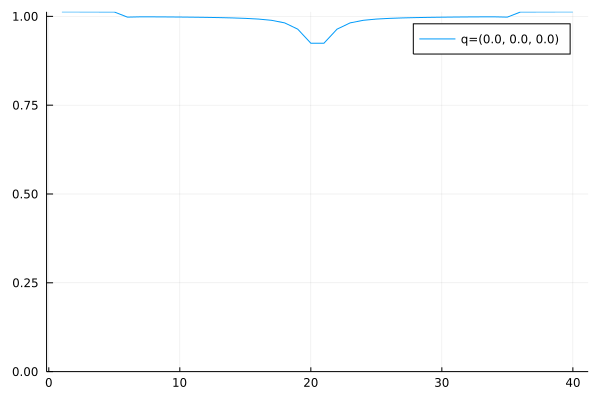

In [8]:
parr = γ_rc_c3
wind = indh
slice = 5:36
ii = 1
yl = (0,maximum(real.(γ_nc[wind,:,:])))
plt = plot(real(parr[wind,1,:]), label="q=$(round.(qG.kGrid[ii], digits=2))", xlabel="νn", legend=:bottomright, ylims=yl)
anim = @animate for ii in 1:size(parr,2)
    plot(real(parr[wind,ii,:]), ylims=yl, label="q=$(round.(qG.kGrid[ii], digits=2))")
end every 1
gif(anim, "realg.gif", fps=1)

In [9]:
plot(real(γ_tmp_nc[indh,2,:]), label="no fit", ylabel="∑_q γsp(νn=0)", xlabel="ωn", legend=:bottomright)
plot!(real(γ_tmp_rc[indh,2,:]), label="richardson")

LoadError: UndefVarError: γ_tmp_nc not defined

In [10]:
wind = indh
slice = 5:36
plot(νIndices[slice], real(γ_tmp_nc[wind,end,slice]), label="no fit", ylabel="∑_q γsp(ωn=$(wind-indh))", xlabel="νn", legend=:bottomright)
plot!(νIndices[slice], real(γ_tmp_rc[wind,end,slice]), label="richardson")

LoadError: UndefVarError: γ_tmp_nc not defined

In [11]:
wind = indh
slice = 5:36
ii = 1
yl = (minimum(imag.(γ_tmp_rc[wind,:,:])),maximum(imag.(γ_tmp_rc[wind,:,:])))
plt = plot(imag(γ_tmp_rc[wind,1,:]), label="q=$(round.(qG.kGrid[ii], digits=2))", xlabel="νn", legend=:bottomright, ylims=yl)
anim = @animate for ii in 1:size(γ_tmp_rc,2)
    plot(imag(γ_tmp_rc[wind,ii,:]), ylims=yl, label="q=$(round.(qG.kGrid[ii], digits=2))")
end every 1
gif(anim, "realg.gif", fps=1)

LoadError: UndefVarError: γ_tmp_rc not defined

In [11]:
# prepare data for plots
γ_nc_ων  = kintegrate(qG,γ_nc, dim=2)
γ_rc_ων = kintegrate(qG,γ_rc, dim=2)
γ_rc_c1_ων = kintegrate(qG,γ_rc_c1, dim=2)
γ_rc_c2_ων = kintegrate(qG,γ_rc_c2, dim=2);
γ_rc_c3_ων = kintegrate(qG,γ_rc_c3, dim=2);
println("maximum imaginary part. naive: $(maximum(imag(γ_nc))), richardson: $(maximum(imag(γ_rc))), mix1: $(maximum(imag(γ_mix1))), mix2: $(maximum(imag(γ_mix2)))")

LoadError: UndefVarError: γ_mix1 not defined

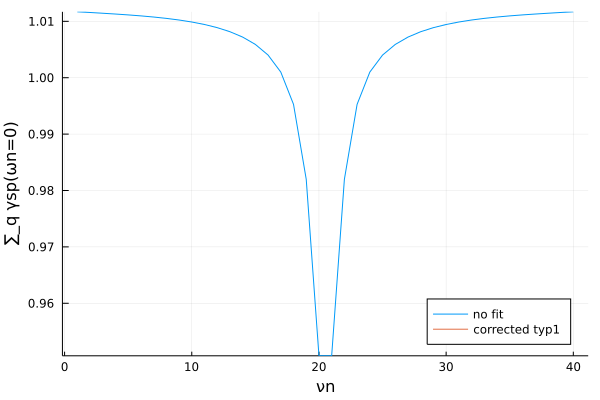

In [12]:
yl = yl = (minimum(real(γ_nc_ων[wind,1,:])),maximum(real(γ_nc_ων[wind,1,:])))
p = plot(real(γ_nc_ων[wind,1,:]), label="no fit", ylabel="∑_q γsp(ωn=$(wind-indh))", xlabel="νn", legend=:bottomright, ylims=yl)
#plot!(real(γ_rc_ων[wind,1,:]), label="fit")
plot!(real(γ_rc_c1_ων[wind,1,:]), label="corrected typ1")
#plot!(real(γ_rc_c2_ων[wind,1,:]), label="corrected typ2")
#plot!(real(γ_rc_c3_ων[wind,1,:]), label="corrected typ3")

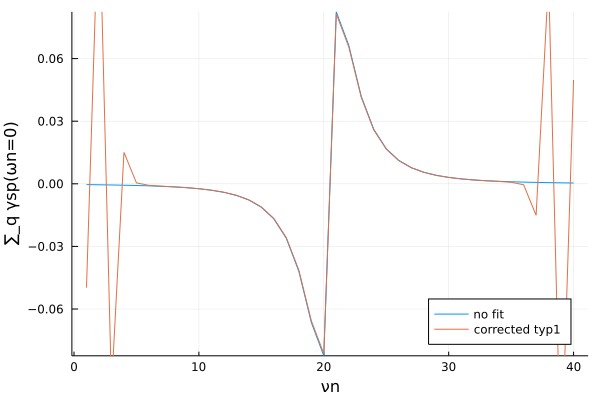

In [13]:
yl = yl = (minimum(imag(γ_nc_ων[wind,1,:])),maximum(imag(γ_nc_ων[wind,1,:])))
p = plot(imag(γ_nc_ων[wind,1,:]), label="no fit", ylabel="∑_q γsp(ωn=$(wind-indh))", xlabel="νn", legend=:bottomright, ylims=yl)
#plot!(imag(γ_rc_ων[wind,1,:]), label="fit")
plot!(imag(γ_rc_c1_ων[wind,1,:]), label="corrected typ1")
#plot!(imag(γ_rc_c2_ων[wind,1,:]), label="corrected typ2")
#plot!(imag(γ_rc_c3_ων[wind,1,:]), label="corrected typ3")